In [1]:
import pandas as pd
import os 

In [2]:
df = pd.read_csv(os.path.join('logs', 'participants.tsv'), sep = '\t')
df.head()

,participant_id,age,sex,hand,date
0,sub-01,21,F,R,2024-10-10
1,sub-02,20,F,R,2024-10-12
2,sub-03,21,M,R,2024-10-13
3,sub-04,21,F,R,2024-10-14
4,sub-05,20,F,R,2024-10-15


In [3]:
# percent male
(df.sex == 'M').mean()

0.33

In [4]:
# percent right handed
(df.hand == 'R').mean()

0.92

In [5]:
# age range
df.age.min(), df.age.max()

(17, 32)

In [6]:
df.age.median(), df.age.mean()

(20.0, 19.95)

In [7]:
from util.preprocessing import calc_detection_counts
from util.io import Layout
from scipy.stats import fisher_exact


layout = Layout(data_dir = 'logs') 

detection_rates = []
for sub in layout.get_subjects():
    df = layout.load_clock_data(sub)
    counts = calc_detection_counts(df, catch = False)
    rm = True if fisher_exact(counts)[1] < .05*2 else False # b/c one-tailed
    df = layout.load(sub, 'masked')
    df = df[~df.practice]
    tpr = df.aware[df.operant & (~df.catch)].mean()
    fpr = df.aware[(~df.operant) & (~df.catch)].mean()
    detection_rates.append(dict(
        subject = sub,
        catch_rate = df.aware[df.catch].mean(),
        hit_rate = tpr,
        false_alarm_rate = fpr,
        excluded = rm and (tpr > fpr)
    ))
rates = pd.DataFrame(detection_rates)
rates.head()

,subject,catch_rate,hit_rate,false_alarm_rate,excluded
0,01,0.7,0.525,0.050,True
1,02,0.9,0.000,0.000,False
2,03,0.9,0.900,0.800,False
3,04,1.0,0.075,0.050,False
4,05,1.0,0.375,0.275,False


(array([ 1.,  0.,  4.,  0.,  4.,  4.,  8.,  0.,  7., 72.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

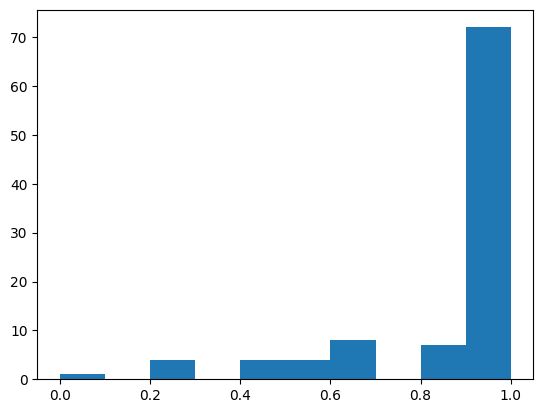

In [8]:
from matplotlib import pyplot as plt
plt.hist(rates.catch_rate)

In [9]:
# how many subjects didn't report seeing catch trials?
rates[rates.catch_rate < .1]

,subject,catch_rate,hit_rate,false_alarm_rate,excluded
98,99,0.0,0.125,0.075,False


sub-99 was left out of analyses of masked trials anyway (see `analysis.ipynb`), since we tested them after already meeting our sample size target.

In [10]:
rates[rates.catch_rate < .1]

,subject,catch_rate,hit_rate,false_alarm_rate,excluded
98,99,0.0,0.125,0.075,False


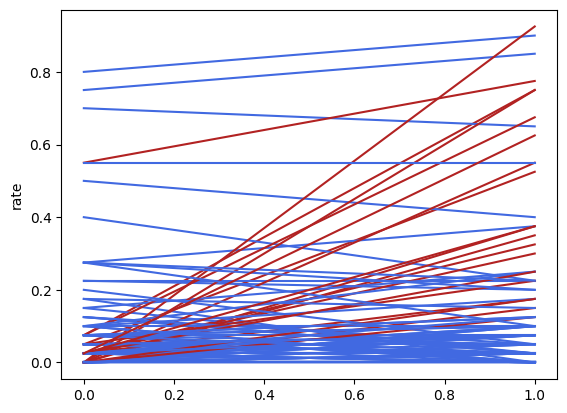

In [11]:
for tpr, fpr, rm in zip(rates.hit_rate, rates.false_alarm_rate, rates.excluded):
    c = 'firebrick' if rm else 'royalblue'
    plt.plot([0, 1], [fpr, tpr], color = c)
plt.ylabel('rate')
plt.show()

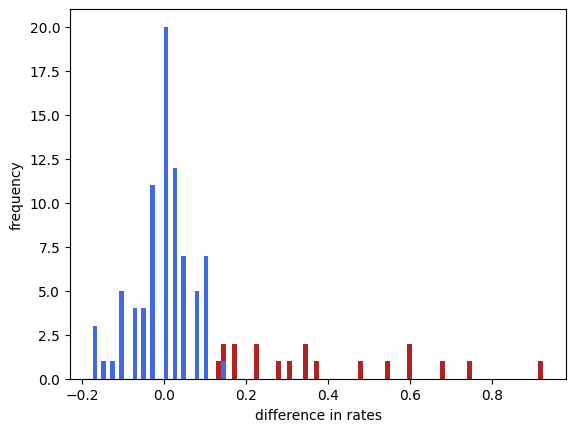

In [12]:
diff = rates.hit_rate - rates.false_alarm_rate
plt.hist(diff[rates.excluded], color = 'firebrick', bins = 60)
plt.hist(diff[~rates.excluded], color = 'royalblue', bins = 30)
plt.xlabel('difference in rates')
plt.ylabel('frequency')
plt.show()

In [13]:
rates.false_alarm_rate.min(), rates.false_alarm_rate.max()

(0.0, 0.8)

In [14]:
rates.false_alarm_rate.median(), rates.false_alarm_rate.mean()

(0.025, 0.09424999999999999)

In [15]:
rates.false_alarm_rate.std()

0.16111413703184196

In [16]:
rates.hit_rate.min(), rates.hit_rate.max()

(0.0, 0.925)